##Summary 

This notebook is to set up functions and modules for data preprocessing, options are given to choose e.g., threshold for filtering, filling strategy for NAs. The notebook is divided into the following steps:

1. Filter out columns that have too many NAs, users can specify the percentage, functions to impute missing values are also given. Filter out also columns that are constant, NA is optionally considered as a meaningful value. 
  **example output: xtrain_narm, xtrain_noconst**
    
2. Numerical columns with very few values are categorized into categorical features. For the rest numerical features, modules are given to do log transform, all integer-valued columns including columns that contain integer values and NA (as float) are first shifted to be positive-valued (with min = 1) and then log transformed if criteria are met according to the normaltest function. The untouched columns are either decimal-valued, or multi-modal distributed
  **example output: nxtrain, nxtrain_shifted, nxtrain_log**

3. Time series data, most of these columns have a lot of NAs. These features are converted into datetime format so that further derivation can be easily constructed.
  **example output: txtrain, txtrain_na_rm**

4. Categorical features fall into three types:
   (1) object-type columns with very few values: these are converted to feature matrices using DictVectorizer
   (2) integer-categorical columns with very few values: these can be converted into categorical with the provided function, yet, the ordinal information will be lost
   (3) object-type columns with a lot of values: these are unchanged so far, may contain states, text, etc.
  **example output: cat_sparse, ordinal_sparse**

Note that now training and testing data are processed together. 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
import requests
from pattern import web
import operator
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn import cross_validation
import gc
from sklearn import metrics
from scipy import stats
from sklearn.base import TransformerMixin
from datetime import datetime as dt
from math import isnan
from numpy import ma

In [6]:
from scipy.sparse import hstack,csr_matrix
import cPickle as pickle

In [7]:
na_values = ['[]','',-1]
train = pd.read_csv('train.csv',na_values = na_values)

C:\Anaconda3\envs\python2\lib\site-packages\pandas\io\parsers.py:1170: DtypeWarning: Columns (8,9,10,11,12,43,157,196,214,225,228,229,231,235,238) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [8]:
test = pd.read_csv('test.csv',na_values = na_values)

C:\Anaconda3\envs\python2\lib\site-packages\pandas\io\parsers.py:1170: DtypeWarning: Columns (8,9,10,11,12,43,157,167,177,196,214,225,228,229,231,235,238) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [9]:
cols = train.columns.tolist()

In [10]:
mixed_col_num = [8,9,10,11,12,43,157,196,214,225,228,229,231,235,238]
mixed_cols = [cols[i] for i in mixed_col_num]

In [11]:
ytrain = train['target']

In [12]:
xtrain = train.drop(['target','ID'],axis = 1)
indices_train = xtrain.index #to be used later for separating train and test data parts

In [13]:
xtest = test.drop(['ID'],axis = 1)
#shift the index of test data before concat
indices_test = xtest.index
indices_test = indices_test + xtrain.shape[0] 
xtest.index = indices_test

In [14]:
#release memory
%xdel train
%xdel test

In [15]:
xtotal = pd.concat([xtrain, xtest])
indices_total = xtotal.index

In [16]:
%xdel xtest
print xtrain.shape
print xtotal.shape

(145231, 1932)
(290463, 1932)


###Pre-processing Parameters

In [20]:
dropNA = True       #drop columns with NAs > than dropNAThresh. This will also change the behavior of dropconstant_col.
dropNAThresh = 0.98 #percentage

separate_cat_num_thresh = 1 #treat those numerical variables with less than th unique values as categorical

dropNA_time= True
dropNAThresh_time = 0.75 #for time and dates

dropNA_cat = False #perform additional nan dropping to categorical data
dropNAThresh_cat = 0.75 #for categorical data

outlierThresh = 5
outlierUniqueThresh = 20 #if number of unique values in a column is less than this threshold, do not apply outlier removal.
remove_personal_income_outlier = False #do not remove outlier in personal income

fillNAStrategy_numeric= 'mean' # 'mode', 'median', 'mean', or number
fillNAStrategy_time = 'median'#strategy for filling missing values in the original time variables
fillNAStrategy_time_derived = 'mode'#strategy for filling missing values in the derived time variables
fillNAStrategy_cat_num = 'mode' #strategy for filling missing values in categorical variables which are numeric type

##1.Filter columns based on number of missing values and unique values 

In [15]:
class DataFrameFilter(TransformerMixin):
    def __init__(self):
        """
        Filter feature columns based on nan values and/or constant values
        To transform, target must be specified as either "nan" or "constant"
        
        """
    def fit(self,X,y=None):
        return self
        
    def transform(self, X, y=None, target = 'nan',thresh = 0.98):
        """
        X is the feature dataframe, target can be "nan" or "constant", 
        thresh is the fraction of nans or the constant value that justifies the 
        feature column to be filtered
        """
        if target != 'nan' and target != 'constant':
            raise KeyError('Invalid target, valide targets are nan and constant')
        elif target == 'nan':
            num_nan = X.isnull().sum()
            perc_nan = num_nan.apply(lambda x: float(x)/(X.shape[0]))
            return X.drop([x for x in perc_nan.index if perc_nan[x] > thresh],axis = 1)
        else:
            const_fraction = X.apply(lambda x: x.value_counts(normalize=True,dropna = False).values[0])
            kept_cols = const_fraction[const_fraction < thresh].index.tolist()
            return X[kept_cols]

In [16]:
dffilter = DataFrameFilter()

In [17]:
if dropNA:
    xtotal = dffilter.transform(xtotal)

In [18]:
xtotal = dffilter.transform(xtotal,target = 'constant')

In [19]:
xtotal.shape

(145231, 1722)

###Missing value imputation 

this step can also be done with the ML models, e.g., for example, xgboost has option to impute the values

In [20]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with median,mean,mode or a certain number e.g., -999.

        """
    def fit(self, X, y=None,strategy = 'median'):

        fill_list = []
        for col in X.columns:
            if X[col].dtype == np.dtype('O') or strategy == 'mode':
                fill_list.append(X[col].value_counts().index[0])
            else:
                if strategy == 'median':
                    fill_list.append(X[col].median())
                elif strategy == 'mean':
                    fill_list.append(X[col].mean())
                elif type(strategy) in [int,float]:
                    fill_list.append(float(strategy))
                else:
                    print 'unknown method of filling, leave nan'
                    fill_list.append(np.nan)
        
        self.fill =pd.Series(fill_list,index = X.columns)
        return self

    def transform(self, X, y=None,strategy = 'median'):
        return X.fillna(self.fill)

###Remove Outliers using median-absolute-deviation

In [21]:
def remove_outliers_mad(data, thresh=3.5, outlier_uq_thresh=20):
    '''
    detect outliers using median-absolute-deviation (MAD)
    input: data:   dataframe or series
           thresh: threshold
           outlier_uq_thresh: if number of unique values in a column is less than this threshold, 
                   outlier removal will not be applied to that column. 
    output:num_outliers
           num_outliers: count of outliers
    '''
    abs_deviation = (data - data.median()).abs()
    median_abs_deviation = abs_deviation.median()
    zero_mad = median_abs_deviation==0
    if len(data.shape)==1:
        if zero_mad:
            median_abs_deviation = 1
    else:
        median_abs_deviation[zero_mad] = 1  
   
    modified_z_score = (0.6745 * abs_deviation / median_abs_deviation)>thresh
    
    if len(data.shape)==1:
        if zero_mad:
            modified_z_score.loc[:]=False
    else:
        modified_z_score[zero_mad[zero_mad].index] = False 
    
    #check number of unique values
    if len(data.shape)==1:
        num_unique = data.nunique(dropna=True)
    else:
        num_unique = data.apply(lambda x: x.nunique(dropna=True),axis = 0)
        
    if len(data.shape)==1:
        if num_unique < outlier_uq_thresh:
            modified_z_score.loc[:]=False
    else:
        modified_z_score[num_unique[num_unique < outlier_uq_thresh].index] = False
        
    data[modified_z_score]=np.nan

    return data, modified_z_score.sum()

##2. Time series data 

In [22]:
time_cols = set(['VAR_0073','VAR_0075','VAR_0156','VAR_0157',
           'VAR_0158','VAR_0159','VAR_0166','VAR_0167','VAR_0168','VAR_0169',
           'VAR_0176','VAR_0177','VAR_0178','VAR_0179','VAR_0204','VAR_0217','VAR_0314','VAR_0531']).intersection(set(xtrain.columns))

In [23]:
time_cols = list(time_cols)
time_cols.sort()

In [24]:
class TimeSeriesTransform(TransformerMixin):
    def __init__(self):
        """
        convert time series columns from string-valued to datetime obj
        """
    
    def fit(self,X, y= None):
            return self
    
    def convertdatetime(self,string,form = '%d%b%y:%H:%M:%S'):
        """
        convert datetime string to datetime obj
        inputs: string, form: the format of the string
        output: the datetime obj
        """
        if type(string) == str or type(string) == np.string_:
            return pd.to_datetime(string,format = form)
    
    def transform(self,X, y=None):
        """
        X is the sub-dataframe of time serie columns,
        the current set-up relies on the correct numbering of the columns, namely, 
        there are 15 ts columns in total, and the last two are 0314 and 0531
        """
        cols = X.columns.tolist()
        X1 = X.ix[:,:13].applymap(self.convertdatetime)
        X2 = X['VAR_0314'].copy()
        X3 = X['VAR_0531'].copy()
        notnull_0314 = X2[X2.notnull()].index.tolist()
        notnull_0531 = X3[X3.notnull()].index.tolist()
        X2[notnull_0314] = X.ix[notnull_0314,'VAR_0314'].astype(int).astype(str).apply(self.convertdatetime,form = '%Y')
        X3[notnull_0531] = X.ix[notnull_0531,'VAR_0531'].astype(int).astype(str).apply(self.convertdatetime,form = '%Y%m')
        X_tmp = pd.concat([X2,X3],axis = 1)
        return pd.concat([X1,X_tmp],axis = 1)

In [25]:
tstransform = TimeSeriesTransform()

In [26]:
txtotal_raw = xtotal[time_cols]

In [27]:
txtotal = tstransform.transform(txtotal_raw)

#####Consider dropping columns that have more than 50% NAs 

Derivative features such as the difference between each two time series columns can be constructed directly by substraction of one column from the other, these can be generated later

In [28]:
class TimeSeriesDerivatives(TransformerMixin):
    def __init__(self):
        """
        Adding derived time series columns (duration, year, month, day, weekday, epoch time) 
        from string-valued to datetime obj
        """
    
    def fit(self,X, y= None):
            return self
        
    def transform(self,X, y=None, option=1):
        """
        X is the sub-dataframe of time serie columns
        option = 1: adding derived variables
        option = 0: only convert the original datetime to days since 1970-1-1
        It is assumed that the column names are in this format :"VAR_xxxx", 
        where "xxxx" represents the variable number.
        """
        cols = X.columns
        if option==1:
            cols_derived = []
            #duration variables, in days
            for i in range(len(cols)-1):
                for j in range(i+1, len(cols)):
                    time_dif=(X[cols[i]]-X[cols[j]]).astype('timedelta64[D]')
                    dif_var_name=cols[i][4:]+'-'+cols[j][4:]
                    X[dif_var_name]=time_dif
                    cols_derived.append(dif_var_name)
            #year, month, day, weekday
            for i in cols:
                X[i+'year']=X[i].dt.year
                X[i+'month']=X[i].dt.month
                X[i+'day']=X[i].dt.day
                X[i+'weekday']=X[i].dt.weekday
                cols_derived.append(i+'year')        
                cols_derived.append(i+'month')
                cols_derived.append(i+'day') 
                cols_derived.append(i+'weekday') 
        #convert the time into days since 1970-01-01
        for i in cols:
            X[i] = X[i].astype(np.int64)// 10**9 
        return X, cols_derived

In [29]:
if dropNA_time:
    txtotal_nona = dffilter.transform(txtotal,target = 'nan',thresh = dropNAThresh_time)
    time_cols_ori = txtotal_nona.columns
    print 'Remove time columns with {}% of nan. There are {} columns left'.format(dropNAThresh_time*100, txtrain_nona.shape[1])
else:
    txtotal_nona=txtotal.copy()
    time_cols_ori = time_cols


Remove time columns with 75.0% of nan. There are 6 columns left


In [30]:
ts_derivative_transform = TimeSeriesDerivatives()
txtotal_nona_new, time_cols_derived = ts_derivative_transform.transform(txtotal_nona)

In [31]:
#remove outliers
#do not apply outlier removal to var_0204, since it is near the end of the month or the beginning of the next month. 
temp = txtotal_nona_new['VAR_0204day'].copy() 
txtotal_nona_new, outliers_time_count = remove_outliers_mad(txtotal_nona_new, outlierThresh)
txtotal_nona_new['VAR_0204day'] = temp

In [32]:
#fillin missing values in txtrain
# derived variables
txtotal_nona_new_d = DataFrameImputer().fit_transform(txtotal_nona_new[time_cols_derived],strategy = fillNAStrategy_time_derived)
# original variables
txtotal_nona_new_o = DataFrameImputer().fit_transform(txtotal_nona_new[time_cols_ori],strategy = fillNAStrategy_time)

##3. Separate numerical vs categorical features

In [33]:
class DataFrameSep(TransformerMixin):
    def __init__(self):
        """
        separate numerical and categorical feature columns 
        the transform returns two dataframes, one for each
        """

    def fit(self,X,y=None):
        return self
    
    def transform(self,X, y=None,thresh = 10, dropna = True):
        """
        this function separates the numerical and non-numerical columns, output two lists of column names
        input:  X, feature dataframe
                thresh, number of unique values such that if a column has no more than this number of unique values,
                it is treated as categorical even if the dtype is numerical
                dropna, if False, nan is counted as an unique value when compare # of unique values with the thresh
        output: cX: dataframe of categorical features
                nX: dataframe of numerical features

        """
        cat = X.dtypes == 'object'
        cat_cols = X.dtypes[cat].index.tolist()
        raw_num_cols = X.dtypes[~cat].index.tolist()
        num_unique = X[raw_num_cols].apply(lambda x: x.nunique(dropna = dropna),axis = 0)
        convert_to_cat_cols = num_unique[num_unique < thresh].index.tolist()
        cat_cols.extend(convert_to_cat_cols)
        num_cols = [x for x in raw_num_cols if x not in convert_to_cat_cols]
        cX,nX = X[cat_cols],X[num_cols]
        return cX,nX

In [34]:
sep = DataFrameSep()

In [35]:
# non_ts_col: non time series columns
non_ts_col = list(set(xtotal.columns).difference(set(time_cols)))

In [36]:
cxtotal,nxtotal = sep.transform(xtotal[non_ts_col])

In [37]:
print 'There are {} qualitative features and {} quantitative features'.format(cxtotal.shape[1],nxtotal.shape[1])

There are 278 qualitative features and 1429 quantitative features


## 4. Numerical features standardization 

Two types of columns
    1. integer_cols, including columns that have float(NA) and integer values
    2. float_cols 

###Remove Outliers

In [38]:
nxtotal, outliers_numeric_count = remove_outliers_mad(nxtotal, thresh=outlierThresh, outlier_uq_thresh=outlierUniqueThresh)
if ~remove_personal_income_outlier:
    nxtotal['VAR_0361']=xtotal['VAR_0361']#recover personal income
    print 'Did not remove outliers in VAR_0361 (personal income)'

###Derived Features

Derived features. 
Assumptions: 0237 represents current state name. 0274 represent former state name. 0361 represents personal income. 
1. relocation: if current state is different from former state.
2. state_average_income_c: average income of each state will be calculated using 0237 and 0361. Then a new column is created based on the state name shown in 0237 and the average income of that state. 
3. state_average_income_f: Similarly, another column is created based on 0274.
4. relative_personal_income: VAR0361, personal income - average income of the state (0237). 
5. relative_personal_income_binary: relative_personal_income <0
6. relocation_personal_income: average personal income of current state - average personal income of former state, 
reflects the change in the average income levels due to relocation. 
7. state_positive_response_c: counts of y=1 for each state, by groupping ytrain by 0237. Using train data only.
8. state_positive_response_f: counts of y=1 for each state, by groupping ytrain by 0274. Using train data only.
9. state_total_responce_c: convert 0237 to a new column based on value counts. Typos set to nan.
10.state_total_responce_f: convert 0274 to a new column based on value counts. Typos set to nan. 

Normalization: except for 1 and 5 which are binary, all the other variables will be processed as numerical features. 
1 and 5 will join the numerical features, after the normalization procedures.

For creating features 7 and 8 related to positive responses, only the training part of the data was used. 
Since total response is calculated as the counts of entries in each state, both training and testing data can be used. 

In [39]:
# states_current = cxtrain['VAR_0237'].copy()#these two variables will also be used in creating the relocation variables
# states_former =  cxtrain['VAR_0274'].copy()#after the log transform etc. 
##there some typos in the states_former, first get the full list of US states names
##an alternative approach is to correct these as DE, GA, TN, and xx, not sure what is RR. Will try it later if had time. 
##create a list of all the state names, 52 in total, including DC and PR
# us_states= list(set(states_former.value_counts().index)-set(['EE', 'GS', 'RN', 'RR'])) 
# with open('us_states.dat', 'wb') as us_states_outfile:
#     pickle.dump(us_states, us_states_outfile)

#load in manually checked state names, for checking typos
with open('us_states.dat', 'rb') as us_states_infile:
    us_states = pickle.load(us_states_infile)

In [40]:
def check_typo_state_name(state_names, us_states):
    num = len(state_names)
    typos = [state_names[i] for i in range(num) if state_names[i] not in us_states]
    return len(typos), typos

In [42]:
states_current = cxtotal['VAR_0237'].copy()
states_former =  cxtotal['VAR_0274'].copy()

states_current_names = list(set(states_current.value_counts().index))
states_former_names = list(set(states_former.value_counts().index))

#check typos by comparing it with the full list of US states.
num_typos_current, states_names_typos_c = check_typo_state_name(states_current_names, us_states)
num_typos_former, states_names_typos_f = check_typo_state_name(states_former_names, us_states)

In [23]:
np.nan != 'CA'

True

In [43]:
#relocation. This variable will join numerical data later
missing_former_address = (~states_current.isnull())&states_former.isnull() #former address is missing
states_former[missing_former_address]=states_current[missing_former_address]#fill in former with current

#even if there are typos in states_former, relocation is still calculated normally.
relocation = states_current!=states_former 

#if current is null, but former is available, assuming no change in address
relocation[states_current.isnull()&~(states_former.isnull())] = False

#if both states_current and states_former are null, assumming no change in address
relocation[states_current.isnull()&states_former.isnull()] = False

if sum(relocation.isnull())>0:
    #fill any NaN with mode
    relocation_mode = relocation.value_counts().index[0]
    relocation = relocation.fillna(relocation_mode) 

In [44]:
# relative_personal_income, relocation_personal_income and relative_personal_income_binary
personal_income = xtotal['VAR_0361'].copy()

relative_personal_income = pd.Series(index = indices_total, dtype = personal_income.dtypes)#series of NaN
relocation_personal_income = pd.Series(index = indices_total, dtype = personal_income.dtypes)#series of NaN

state_and_income = pd.concat([states_current, personal_income],axis=1)
state_average_income = state_and_income.groupby('VAR_0237').mean()['VAR_0361'].to_dict() #average income in each state

state_income_na_indices = state_and_income.isnull().any(axis=1) #either current state or personal income is missing
indices_temp = state_and_income[~state_income_na_indices].index

for i in indices_temp:
    income_temp = personal_income[i]
    state_current_temp  = states_current[i]
    state_former_temp = states_former[i]
    average_income_current_temp = state_average_income.get(state_current_temp, np.nan)
    average_income_former_temp = state_average_income.get(state_former_temp, np.nan)
    relative_personal_income[i] = income_temp - average_income_current_temp #relative personal income
    relocation_personal_income[i] = average_income_current_temp - average_income_former_temp #differences in personal income

relative_personal_income_binary = relative_personal_income < 0 #this feature will join numerical data later

rpib_mode = relative_personal_income_binary.value_counts().index[0] 
relative_personal_income_binary = relative_personal_income_binary.fillna(rpib_mode) #fill NA with mode

In [45]:
#positive response and total response for each state. 
#Note that the positive response dictionary is calculated from the training data.
response = ytrain.copy()
state_and_response_c = pd.concat([states_current.loc[indices_train], response],axis=1)
state_and_response_f = pd.concat([states_former.loc[indices_train], response],axis=1)

pos_response_c_dict = state_and_response_c.groupby('VAR_0237').sum()['target'].to_dict() #counts of y=1 in each state
pos_response_f_dict = state_and_response_f.groupby('VAR_0274').sum()['target'].to_dict() #counts of y=1 in each state

tot_response_c_dict = states_current.value_counts().to_dict() #using both training and testing to coutn num of entries
tot_response_f_dict = states_former.value_counts().to_dict() #using both training and testing

#initialization
state_average_income_c = pd.Series(index = indices_total, dtype = personal_income.dtypes)#current state: c
state_average_income_f = pd.Series(index = indices_total, dtype = personal_income.dtypes)#former state: f
state_positive_response_c = pd.Series(index = indices_total, dtype = response.dtypes)
state_positive_response_f = pd.Series(index = indices_total, dtype = response.dtypes)
state_total_response_c = pd.Series(index = indices_total, dtype = response.dtypes)
state_total_response_f = pd.Series(index = indices_total, dtype = response.dtypes)
#using current state
indices_states_c = states_current[states_current.notnull()].index
for i in indices_states_c:
    state_temp = states_current[i]
    if state_temp in us_states: #excluding any typos
        state_average_income_c[i] = state_average_income.get(state_temp, np.nan)
        state_positive_response_c[i] = pos_response_c_dict.get(state_temp, np.nan)
        state_total_response_c[i] = tot_response_c_dict.get(state_temp, np.nan)
#using former state
indices_states_f = states_former[states_former.notnull()].index
for i in indices_states_f:
    state_temp = states_former[i]
    if state_temp in us_states: #excluding any typos
        state_average_income_f[i] = state_average_income.get(state_temp, np.nan)
        state_positive_response_f[i] = pos_response_f_dict.get(state_temp, np.nan)
        state_total_response_f[i] = tot_response_f_dict.get(state_temp, np.nan)

In [46]:
#add the derived features to nxtrain    
nxtotal['relative_personal_income'] = relative_personal_income
nxtotal['relocation_personal_income'] = relocation_personal_income
nxtotal['state_average_income_c'] = state_average_income_c
nxtotal['state_average_income_f'] = state_average_income_f
nxtotal['state_positive_response_c'] = state_positive_response_c
nxtotal['state_positive_response_f'] = state_positive_response_f
nxtotal['state_total_response_c'] = state_total_response_c
nxtotal['state_total_response_f'] = state_total_response_f

### Shift feature values to positive

In [47]:
class ShiftPostive(TransformerMixin):
    def __init__(self):
        """
        shift selected numerical columns to positive value
        """
        
    def fit(self,X, y=None):
        return self
    
    def test_int(self,colvector):
        """
        test if the float dtype columns have no non-integer values other than NA
        input: column vector
        output: boolean, True if the column has no non-integer value other than NA
        """
        return colvector[colvector.notnull()].apply(lambda x:x.is_integer()).sum() == len(colvector[colvector.notnull()])

    def transform(self,X,y=None, int_amount = 1, deci_amount = 0.1):
        # separate out integer vs float-valued columns
        int_cols = X.dtypes[X.dtypes == np.dtype('int64')].index.tolist()
        float_cols = X.dtypes[X.dtypes == np.dtype('float64')].index.tolist()
        int_with_nans_bool = X[float_cols].apply(self.test_int)
        int_with_nans = int_with_nans_bool[int_with_nans_bool].index.tolist()
        int_cols.extend(int_with_nans)
        float_cols = list(set(float_cols).difference(set(int_with_nans)))
        # shift integer-valued columns and float valued columns separately
        new_int_df = X[int_cols].apply(lambda x: x - x.min() + int_amount if x.min() <= 0 else x)
        new_float_df = X[float_cols].apply(lambda x: x - x.min() + deci_amount if x.min() <= 0 else x)
        return pd.merge(new_int_df,new_float_df,left_index=True,right_index=True),int_cols,float_cols

In [48]:
shiftpos = ShiftPostive()

In [49]:
nxtotal_shifted,int_cols,float_cols = shiftpos.transform(nxtotal)

In [ ]:
#release memory
%xdel nxtotal

A few columns in float_cols have 99.0 as maximum, 99.0 is suspected to be NAs, may replace with nan later to test; Also, all float_cols are non-negative with minimum equals zero

###Log transform to highly right-skewed features

In [50]:
class LogTransform(TransformerMixin):
    def __init__(self):
        """
        perform log transformation to columns that are uni-modal and right skewed
        """
    def fit(self,X,y=None):
        return self
    
    def normaltest(self,colvec,test = 'normal'):
        """
        test if a column feature has normal distribution using the stats.mstats.normaltest, skewtest, or kurtosistest
        notably, strong multi-modal data will have a masked value returned from kurtosis test, therefore can be filtered
        after this function is called
        input: colvec, column vector, in the format of pandas series
                test: 'normal', 'skew','kurtosis'
        output: 
            for normal:
            k^2 + s^2, where k and s are the Z-score returned by the kurtosis test and the skew test
            for a perfect normal distribution, k is 3 and s is zero
            for skew or kurtosis:
            z-score 
        """
        if test == 'normal':
            return stats.mstats.normaltest(colvec[colvec.notnull()])[0]
        elif test == 'skew':
            return stats.mstats.skewtest(colvec[colvec.notnull()])[0]
        elif test == 'kurtosis':
            return stats.mstats.kurtosistest(colvec[colvec.notnull()])[0]
        else:
            print 'unknown test type'
            return
    
    def transform(self,X,y=None,thresh = 5000):
        #1. apply normal test and determine cols to transform
        test_results = X.apply(self.normaltest)
        multi_modal_cols = test_results[test_results.apply(lambda x: x is ma.masked)].index.tolist()
        to_transform_cols = test_results[test_results > thresh].index.tolist()
        #2. perform log transform
        transformed_cols = X[to_transform_cols].apply(lambda x: np.log(x) if test_results[x.name] > thresh else x)
        cols = X.columns.tolist()
        unchanged_cols = list(set(cols).difference(set(to_transform_cols)))
        return pd.merge(X[unchanged_cols],transformed_cols,right_index = True,left_index=True)

In [51]:
logtrans = LogTransform()

In [52]:
nxtotal_log = logtrans.transform(nxtotal_shifted)

In [ ]:
#release memory
%xdel nxtrain_shifted

###Standardize numerical data using standardscaler, first need to impute 

This leaves us no choice but impute some reasonable values e.g., median, mode, mean if we want to scale the matrix

In [53]:
imputer = DataFrameImputer()

In [54]:
nxtotal_imputed = imputer.fit_transform(nxtotal_log,strategy = 'median')

In [55]:
%xdel nxtrain_log #release memory

In [ ]:
scaler = StandardScaler()

In [56]:
nxtotal_standard = scaler.fit_transform(nxtotal_imputed.as_matrix())

(145231L, 1437L)

In [ ]:
#release memory
%xdel nxtrain_imputed

In [ ]:
nxtotal_standard.shape

###Add relocation and relative_personal_income_binary to the end of the numerical features. 
#####The last 10 columns in numerical features correspond to the derived features. 

In [57]:
rows, cols = nxtotal_standard.shape
nxtotal_standard_new = np.zeros((rows, cols+2))
nxtotal_standard_new[:,:-2] = nxtotal_standard
nxtotal_standard_new[:,-2] = relative_personal_income_binary.values
nxtotal_standard_new[:,-1] = relocation.values

In [58]:
#release memory
%xdel nxtrain_standard

In [59]:
nxtotal_standard_new.shape

(145231L, 1439L)

#####Some extra functions 

In [60]:
# define a plot hist function using log scale
def counthist(feature_name,ax):
    """
    the feature column must be non-negative
    0.1 is added to the feature column such that the column is positive
    inputs: feature_name, the column name, ax, the current axis
    outputs: a hist plot that has x axis on log scale
    """
    feature = nxtrain[feature_name] + 0.1
    start = np.log10(feature.min());stop = np.log10(feature.max())
    ax.set_xscale('log')
    feature.hist(bins = np.logspace(start,stop,30),ax = ax,label = feature_name)
    ax.legend(loc = 'best',fontsize = 'medium')

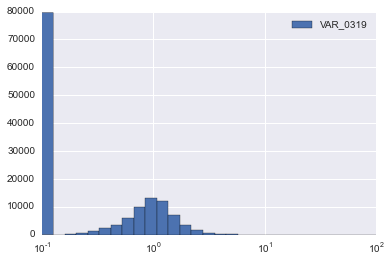

In [61]:
ax = plt.gca()
counthist('VAR_0319',ax)

##4. Categorical features 

##### categorical columns divide into two types, obj-type columns and ordinal(numerical)-type columns

In [62]:
cxtotal.shape

(145231, 278)

In [76]:
def consolidate(strings_input):
    """
    Transform in-place the given dataset by consolidating
    rare categorical features into a single category.
    """
    strings_consolidate = strings_input.copy()
    strings_value_counts =  strings_input.value_counts()
    rare_strings = strings_value_counts[strings_value_counts==1].index
    for i in rare_strings:
        strings_consolidate[strings_input==i]='rare_string'
    return strings_consolidate

#####First, object-type

In [64]:
obj_cols = cxtotal.dtypes[cxtotal.dtypes == 'object'].index.tolist()
num_cat_cols = cxtotal.dtypes[cxtotal.dtypes != 'object'].index.tolist()

In [68]:
if dropNA_cat:
    cxtotal_obj_nona = dffilter.transform(cxtotal[obj_cols],target = 'nan',thresh = dropNAThresh_cat)
    print 'Remove text columns with {}% of nan. There are {} columns left'.format(dropNAThresh_cat*100, cxtrain_obj_nona.shape[1])

In [80]:
class CatVectorize(TransformerMixin):
    def __init__(self):
        """
        wrapper to use DictVectorizer to transform obj-type categorical features
        """
    def fit(self,X,y=None):
        return
    
    def cat_vectorize(self,X):
        """
        vectorize the categorical features of the input dataframe
        take the two columns VAR_0001, and VAR_0005 for example,
            cat_vectorize(cxtrain,obj_cols[:2])
            for each feature, each value is used to construct a binary feature, since there are 7 values in total
            for the two features combined, the transformed matrix has seven columns, corresponding column values are
            stored in encoder.feature_names

        Notably, NA is encoded as a value by filling NAs with 'NA' first

        inputs: df, dataframe; cols, list of columns to be transformed
        output: data_mt, encoded sparse matrix, can be converted to array with "toarray" method
                encoder.feature_names, explained above
        """
        data = X.fillna('NA')
        datadict = data.T.to_dict().values()
        encoder = DictVectorizer()
        data_mt = encoder.fit_transform(datadict)
        return encoder.feature_names_,data_mt
    
    def transform(self,X,y=None,thresh=None):
        """
        inputs
            thresh: is the maximum num of values a column can have to be qualified for the transformation
            columns that have more than thresh number of values are likely states, or description that may need NLP
            X: df of categorical features
        outputs:
            X_vect, the sparse matrix contains only the converted features
            other_cols, list of the other obj-type columns that have more than thresh number of values
            feature_names, the corresponding feature values used as columns in X_vect
        """
        if thresh:
            value_counts = X.apply(lambda x: x.nunique(dropna = False))
            obj_cols = value_counts[value_counts < thresh].index.tolist()
            other_cols = list(set(X.columns).difference(set(obj_cols)))
            X_to_trans = X[obj_cols]
        else:
            X_to_trans = X.copy()
        feature_names,X_vect = self.cat_vectorize(X_to_trans)   
        return X_vect,feature_names,other_cols

In [ ]:
#consolidate VAR_0200: city names
print len(cxtotal['VAR_0200'].value_counts())
temp1 = cxtotal['VAR_0200'].copy()    
temp2 = consolidate(temp1)
cxtotal['VAR_0200'] = temp2 
print len(cxtotal['VAR_0200'].value_counts())

In [81]:
vect = CatVectorize()

In [93]:
if dropNA_cat:
    obj_sparse,feature_names,other_cols = vect.transform(cxtotal_obj_nona,thresh = 9700)
else:
    obj_sparse,feature_names,other_cols = vect.transform(cxtotal[obj_cols],thresh = 9700)

In [97]:
if len(other_cols)>0:
    #for other_cols, apply simple label encoding
    imputer_cat = DataFrameImputer()
    cxtotal_others_imputed = cxtotal[other_cols].fillna('NA') #fill NaN with NA
    le = LabelEncoder()
    for c in cxtotal_others_imputed.columns:
        cxtotal_others_imputed[c]=le.fit_transform(cxtotal_others_imputed[c].astype(str))
    print 'Label encoding the other columns'

In [98]:
#categorical features with numerical data type, simply fillna with mode. No additional transformation.
imputer = DataFrameImputer()

In [ ]:
cxtotal_num_imputed = imputer.fit_transform(cxtotal[num_cat_cols],strategy = fillNAStrategy_cat_num)

In [99]:
if len(other_cols)>0:
    #combine cxtotal_num_imputed and cxtotal_others_imputed
    cxtotal_num_imputed = pd.concat([cxtotal_num_imputed, cxtotal_others_imputed], axis=1)

#####For numerical columns with fewer than threshold (e.g., 10, as a result of previous filtering thresh) numerical values, conversion to categorical will lead to lost of ordinal info; care must be taken; However, if we want to transform, here are the functions

In [100]:
# ordinal_col = cxtrain.dtypes[cxtrain.dtypes != 'object'].index.tolist()

In [101]:
class OrdiVectorize(TransformerMixin):
    def __init__(self):
        """
        vectorize ordinal columns, namely numerical columns with fewer than the previous thresh num of values
        see DataFrameSep for details
        """
    def fit(self,X, y=None):
        return self
    
    def ordinal_vectorize(self,X,y=None,strategy = -9999):
        """
        vectorize ordinal columns, first need to label_encode such that discrete values are converted to 
        continuous integer set from 0 to num_values - 1, 

        second, use one hot encoder to convert each value into binary 

        inputs: X, dataframe, strategy, value used to fillna
        outputs: sparse matrix of the transformed feature matrix
        """
        data = X.fillna(strategy)
        le = LabelEncoder()
        hot = OneHotEncoder()
        for col in data.columns:
            data[col] = le.fit_transform(np.array(data[col]))
        # second step: convert each value for each feature into a binary feature using onehot encoder
        # ordinal information is lost 
        data_mt = hot.fit_transform(data.as_matrix())
        return data_mt
    
    def transform(self,X,y=None):
        """
        return self.ordinal_vectorize(X)
        """
        return self.ordinal_vectorize(X)

In [102]:
# vect2 = OrdiVectorize()

In [103]:
# ordi_sparse = vect2.transform(cxtrain[ordinal_col])

In [104]:
# ordi_sparse.shape

##Save processed data to disk 

###Summary of processed data 

Training data:
1. normalized original numerical features stored in "nxtrain_standard_original", 145231 x 1429. 
2. normalized derived numerical features stored in "nxtrain_standard_derived", 145231 x 10. 
3. obj-dtype categorical columns saved in obj_sparse_train, 145231 x 13769, sparse matrix. The original list "obj_cols" contains 18 column names. 
4. categorical features with numerical types stored in "cxtrain_num", 145231 x 260. No transformation was applied at the moment. 
5. original time series stored in txtrain_nona_new_o, 145231 x 6. Those with more than 75% NAs are dropped. 
6. derived time series stored in txtrain_nona_new_d, 145231 x 39. 

Test data:
1. obj-dtype categorical columns saved in obj_sparse_test, 145232 x 13769, sparse matrix. 
2. categorical features with numerical types stored in "cxtest_num", 145232 x 260. No transformation was applied at the moment. 

####1. Save all numeric data 

In [106]:
#separating original and derived numerical features (10 derived features in total)
#nxtrain
nxtrain_standard_original = nxtotal_standard_new[:len(indices_train), :-10]
nxtrain_standard_derived  = nxtotal_standard_new[:len(indices_train), -10:]
#nxtest
nxtest_standard_original = nxtotal_standard_new[len(indices_train):, :-10]
nxtest_standard_derived  = nxtotal_standard_new[len(indices_train):, -10:]

In [108]:
np.save('nxtrain_standard_original',nxtrain_standard_original)

In [109]:
np.save('nxtrain_standard_derived',nxtrain_standard_derived)

In [ ]:
np.save('nxtest_standard_original',nxtest_standard_original)

In [ ]:
np.save('nxtest_standard_derived',nxtest_standard_derived)

#### 2. Save all processed categorical data 

In [104]:
def save_sparse_csr(filename,array):
    np.savez(filename,data = array.data ,indices=array.indices,
             indptr =array.indptr, shape=array.shape )

def load_sparse_csr(filename):
    loader = np.load(filename)
    return csr_matrix((  loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'])

In [ ]:
#separate categorical features in numeric dtypes for cxtrain and cxtest
cxtrain_num = cxtotal_num_imputed.iloc[:len(indices_train),:]
cxtest_num = cxtotal_num_imputed.iloc[len(indices_train):,:]

In [ ]:
#separate train and test sparse matrices
obj_sparse_train = obj_sparse[:len(indices_train), :]
obj_sparse_test = obj_sparse[len(indices_train):, :]
print obj_sparse_train.shape
print obj_sparse_test.shape

In [112]:
with open('cat_numeric_train.dat', 'wb') as cat_outfile1:
    pickle.dump(cxtrain_num, cat_outfile1, pickle.HIGHEST_PROTOCOL)

In [113]:
with open('cat_sparse_train.dat', 'wb') as cat_outfile2:
    pickle.dump(obj_sparse_train, cat_outfile2, pickle.HIGHEST_PROTOCOL)

In [115]:
with open('cat_numeric_test.dat', 'wb') as cat_outfile3:
    pickle.dump(cxtest_num, cat_outfile3, pickle.HIGHEST_PROTOCOL)

In [116]:
with open('cat_sparse_test.dat', 'wb') as cat_outfile4:
    pickle.dump(obj_sparse_test, cat_outfile4, pickle.HIGHEST_PROTOCOL)

####3. Save time series data

In [ ]:
#separate original and derived time series for train and test
# train
txtrain_original= txtotal_nona_new_o.iloc[:len(indices_train),:]
txtrain_derived = txtotal_nona_new_d.iloc[:len(indices_train),:]
#test
txtest_original= txtotal_nona_new_o.iloc[len(indices_train):,:]
txtest_derived = txtotal_nona_new_d.iloc[len(indices_train):,:]

In [117]:
with open('time_series_original_train.dat', 'wb') as time_outfile1:
    pickle.dump(txtrain_original, time_outfile1, pickle.HIGHEST_PROTOCOL)

In [118]:
with open('time_series_derived_train.dat', 'wb') as time_outfile2:
    pickle.dump(txtrain_derived, time_outfile2, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('time_series_original_test.dat', 'wb') as time_outfile3:
    pickle.dump(txtest_original, time_outfile3, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('time_series_derived_test.dat', 'wb') as time_outfile4:
    pickle.dump(txtest_derived, time_outfile4, pickle.HIGHEST_PROTOCOL)

####4. Save target

In [122]:
with open('ytrain.dat', 'wb') as target_outfile2:
    pickle.dump(ytrain, target_outfile2, pickle.HIGHEST_PROTOCOL)